In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import random

/opt/conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 二、动手实现 logistic 回归
1.要求动手从0实现 logistic 回归（只借助Tensor和Numpy相关的库）在人工构造的数据集上进行训练和测试，并从loss以及训练集上的准确率等多个角度对结果进行分析（可借助nn.BCELoss或nn.BCEWithLogitsLoss作为损失函数，从零实现二元交叉熵为选作）


In [2]:
# 人工数据集
data_num = 100
n_data = torch.ones(data_num, 2)
x1 = torch.normal(2 * n_data, 1)
y1 = torch.zeros(data_num)
x2 = torch.normal(-2 * n_data, 1)
y2 = torch.ones(data_num)
features = torch.cat((x1, x2), 0).type(torch.FloatTensor)
labels = torch.cat((y1, y2), 0).type(torch.FloatTensor)
x = features
y = labels


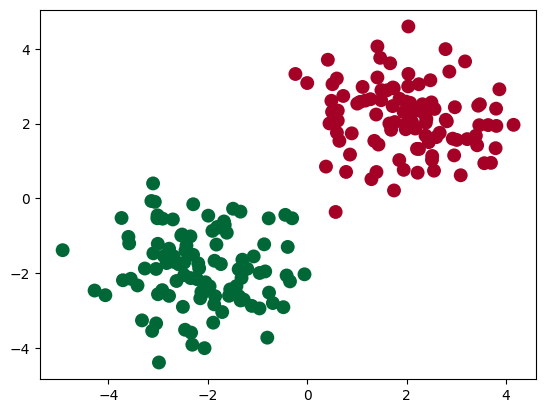

In [3]:
plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

# 测试
for X, y in data_iter(10, features, labels):
    print(X, y)
    break

tensor([[-1.8516, -2.6194],
        [ 1.9822,  1.8475],
        [-2.5325, -0.9946],
        [ 2.9288,  1.5960],
        [ 0.7259,  2.7382],
        [-0.4783, -2.9126],
        [ 1.2925,  0.5126],
        [ 1.7469,  0.2098],
        [-3.4133, -2.3311],
        [-2.0979, -2.5298]]) tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])


In [5]:
# 定义 sigmoid 函数
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# 测试
a = torch.randn(3, 2)
sigmoid(a) == torch.sigmoid(a)

tensor([[True, True],
        [True, True],
        [True, True]])

In [6]:

def binary_cross_entropy(y_hat, y):
    '''
    y_hat: 预测值 shape: (N, 1)
    y: 真实值 shape: (N, 1)
    '''
    return -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat)).mean()

# 测试
a = torch.randn(3, 1)
b = torch.randn(3, 1)
binary_cross_entropy(torch.sigmoid(a), b)==nn.BCELoss()(torch.sigmoid(a), b)

tensor(True)

In [7]:
# 初始化参数
num_inputs = 2
w = torch.normal(0, 0.01, (num_inputs, 1), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
w.requires_grad_(True)
b.requires_grad_(True)

# 定义模型
def logistic(X, w, b):
    return sigmoid(torch.mm(X, w) + b)


# 定义优化器
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            # 根据sgd的公式，这里需要除batch_size
            # 为了与pytorch保持一致，计算loss时采用了.mean()操作，相当于已经除过了batch_size，所以这里不除
            # 经验证，最终实现与pytorch自带的SGD效果一致
            # param -= lr * param.grad / batch_size
            param -= lr * param.grad
            param.grad.zero_()

# 定义准确率
def accuracy(y_hat, y):
    y = y.reshape(-1, 1)
    return ((y_hat > 0.5).float() == y).float().mean().item()

In [8]:
# 定义参数
lr = 0.01  # 学习率
num_epochs = 30  # 训练轮数
batch_size = 10  # 批次大小

model = logistic  # 逻辑回归模型
loss_fn = binary_cross_entropy  # 损失函数：二元交叉熵

train_losses = []  # 记录训练过程中的损失
train_accuracies = []  # 记录训练过程中的准确率

# 训练
for epoch in range(num_epochs):
    epoch_loss = 0  # 当前轮次的损失
    epoch_accuracy = 0  # 当前轮次的准确率
    num_batches = 0  # 当前轮次的批次数量
    
    for X, y in data_iter(batch_size, features, labels):
        pred = model(X, w, b)  # 使用模型进行预测
        loss = loss_fn(pred, y.reshape(-1, 1))  # 计算损失
        loss.backward()  # 反向传播
        sgd([w, b], lr, batch_size)  # 使用随机梯度下降法更新参数
        w.grad.zero_()  # 梯度清零
        b.grad.zero_()  # 梯度清零
        
        epoch_loss += loss.item()  # 累加损失
        epoch_accuracy += accuracy(pred, y)  # 累加准确率
        num_batches += 1  # 批次数量加一
    
    avg_loss = epoch_loss / num_batches  # 计算平均损失
    avg_accuracy = epoch_accuracy / num_batches  # 计算平均准确率
    train_losses.append(avg_loss)  # 记录平均损失
    train_accuracies.append(avg_accuracy)  # 记录平均准确率

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

print(f'Final parameters: w = {w.detach().numpy().flatten()}, b = {b.item():.4f}')

Epoch [1/30], Loss: 0.6122, Accuracy: 0.9500
Epoch [2/30], Loss: 0.4736, Accuracy: 1.0000
Epoch [3/30], Loss: 0.3824, Accuracy: 1.0000
Epoch [4/30], Loss: 0.3197, Accuracy: 1.0000
Epoch [5/30], Loss: 0.2747, Accuracy: 1.0000
Epoch [6/30], Loss: 0.2410, Accuracy: 1.0000
Epoch [7/30], Loss: 0.2149, Accuracy: 1.0000
Epoch [8/30], Loss: 0.1942, Accuracy: 1.0000
Epoch [9/30], Loss: 0.1774, Accuracy: 1.0000
Epoch [10/30], Loss: 0.1634, Accuracy: 1.0000
Epoch [11/30], Loss: 0.1517, Accuracy: 1.0000
Epoch [12/30], Loss: 0.1417, Accuracy: 1.0000
Epoch [13/30], Loss: 0.1330, Accuracy: 1.0000
Epoch [14/30], Loss: 0.1255, Accuracy: 1.0000
Epoch [15/30], Loss: 0.1189, Accuracy: 1.0000
Epoch [16/30], Loss: 0.1130, Accuracy: 1.0000
Epoch [17/30], Loss: 0.1077, Accuracy: 1.0000
Epoch [18/30], Loss: 0.1030, Accuracy: 1.0000
Epoch [19/30], Loss: 0.0987, Accuracy: 1.0000
Epoch [20/30], Loss: 0.0948, Accuracy: 1.0000
Epoch [21/30], Loss: 0.0913, Accuracy: 1.0000
Epoch [22/30], Loss: 0.0880, Accuracy: 1.00

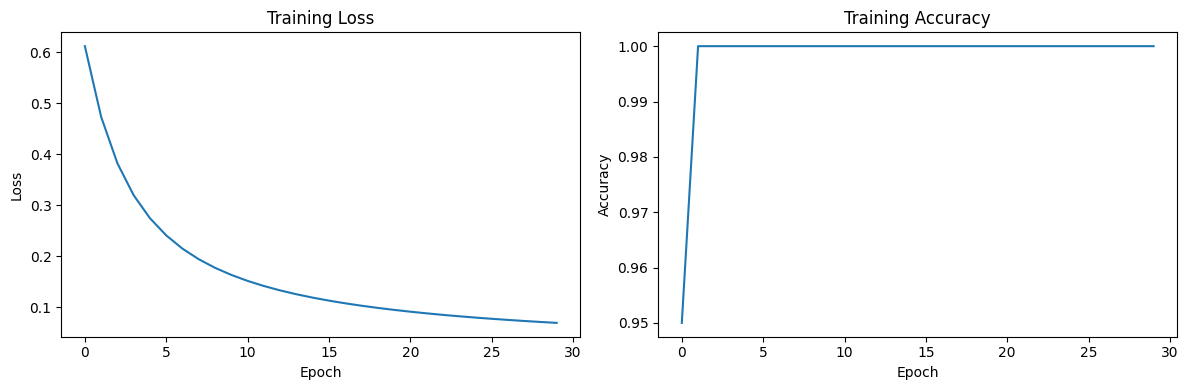

In [9]:
# 可视化结果
def show():
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(train_accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


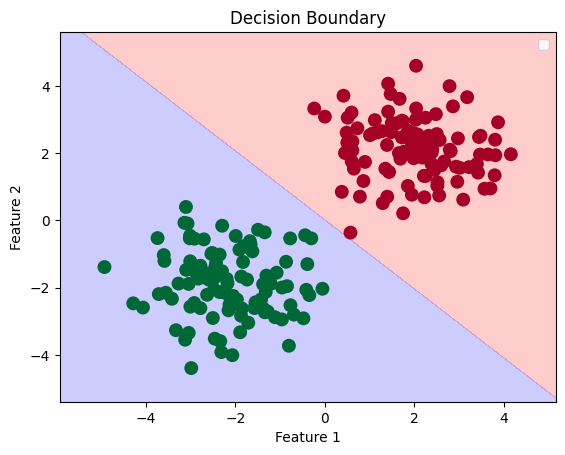

In [10]:
# 定义网格以绘制决策边界
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# 计算每个网格点的预测值
with torch.no_grad():
    probs = model(grid_tensor, w, b).numpy().reshape(xx.shape)

# 绘制等高线和散点图
plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=['red', 'blue'])
plt.scatter(features[:, 0], features[:, 1], c=labels, s=100, lw=0, cmap='RdYlGn')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()


2.利用 torch.nn 实现 logistic 回归在人工构造的数据集上进行训练和测试，并对结果进行分析，并从loss以及训练集上的准确率等多个角度对结果进行分析


In [11]:
import torch.utils.data as Data
# 人工数据集与之前一样
# 超参数设置也与之前保持一致
# 定义参数
lr = 0.01  # 学习率
num_epochs = 30  # 训练轮数
batch_size = 10  # 批次大小

# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 把 dataset 放入 DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,      
    batch_size=batch_size,      
    shuffle=True,               
    num_workers=2,              
) 

for X, y in data_iter:
    print(X, y)
    break

tensor([[ 1.7243,  2.9646],
        [-2.9818, -4.3921],
        [ 1.1697,  2.6138],
        [-2.6857, -1.5533],
        [-3.0096, -0.4560],
        [ 2.9288,  1.5960],
        [-2.7787, -2.6105],
        [-1.2755, -2.7112],
        [ 2.8601,  3.3899],
        [-2.4735, -2.0544]]) tensor([0., 1., 0., 1., 1., 0., 1., 1., 0., 1.])


In [12]:

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(num_inputs, 1)
    def forward(self, x):
        y = torch.sigmoid(self.linear(x))
        return y
    
net = LogisticRegression()
from torch.nn import init
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)   

loss = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [13]:
# 训练
train_losses = []  # 定义一个列表来存储训练过程中的损失值
train_accuracies = []  # 定义一个列表来存储训练过程中的准确率

for epoch in range(num_epochs):  # 循环遍历每个训练周期
    epoch_loss = 0  # 初始化当前周期的损失值为0
    epoch_accuracy = 0  # 初始化当前周期的准确率为0
    num_batches = 0  # 初始化当前周期的批次数量为0

    for X, y in data_iter:  # 遍历数据迭代器中的每个批次
        pred = net(X)  # 使用模型对输入数据进行预测
        y = y.reshape(-1, 1)  # 将真实标签转换为列向量
        l = loss(pred, y)  # 计算预测值和真实值之间的损失
        optimizer.zero_grad()  # 清除优化器中的梯度
        l.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型参数

        epoch_loss += l.item()  # 累加当前批次的损失值
        epoch_accuracy += accuracy(pred, y)  # 累加当前批次的准确率
        num_batches += 1  # 批次数量加1

    avg_loss = epoch_loss / num_batches  # 计算当前周期的平均损失值
    avg_accuracy = epoch_accuracy / num_batches  # 计算当前周期的平均准确率
    train_losses.append(avg_loss)  # 将平均损失值添加到训练损失列表中
    train_accuracies.append(avg_accuracy)  # 将平均准确率添加到训练准确率列表中

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')  # 打印当前周期的损失和准确率

print(f'Final parameters: w = {net.linear.weight.detach().numpy().flatten()}, b = {net.linear.bias.item():.4f}')  # 打印最终的模型参数

Epoch [1/30], Loss: 0.5419, Accuracy: 0.9700
Epoch [2/30], Loss: 0.3500, Accuracy: 1.0000
Epoch [3/30], Loss: 0.2570, Accuracy: 1.0000
Epoch [4/30], Loss: 0.2038, Accuracy: 1.0000
Epoch [5/30], Loss: 0.1698, Accuracy: 1.0000
Epoch [6/30], Loss: 0.1463, Accuracy: 1.0000
Epoch [7/30], Loss: 0.1289, Accuracy: 1.0000
Epoch [8/30], Loss: 0.1156, Accuracy: 1.0000
Epoch [9/30], Loss: 0.1051, Accuracy: 1.0000
Epoch [10/30], Loss: 0.0966, Accuracy: 1.0000
Epoch [11/30], Loss: 0.0895, Accuracy: 1.0000
Epoch [12/30], Loss: 0.0835, Accuracy: 1.0000
Epoch [13/30], Loss: 0.0784, Accuracy: 1.0000
Epoch [14/30], Loss: 0.0740, Accuracy: 1.0000
Epoch [15/30], Loss: 0.0701, Accuracy: 1.0000
Epoch [16/30], Loss: 0.0667, Accuracy: 1.0000
Epoch [17/30], Loss: 0.0636, Accuracy: 1.0000
Epoch [18/30], Loss: 0.0609, Accuracy: 1.0000
Epoch [19/30], Loss: 0.0585, Accuracy: 1.0000
Epoch [20/30], Loss: 0.0562, Accuracy: 1.0000
Epoch [21/30], Loss: 0.0542, Accuracy: 1.0000
Epoch [22/30], Loss: 0.0523, Accuracy: 1.00

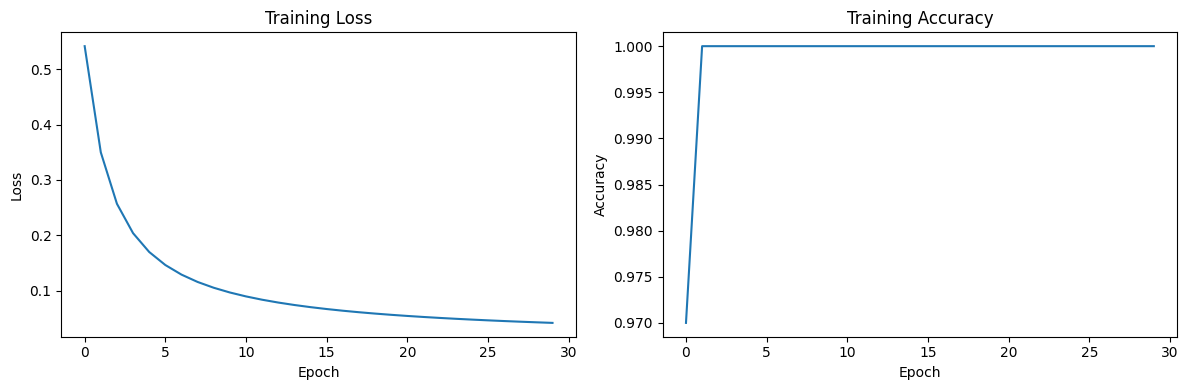

In [14]:
show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


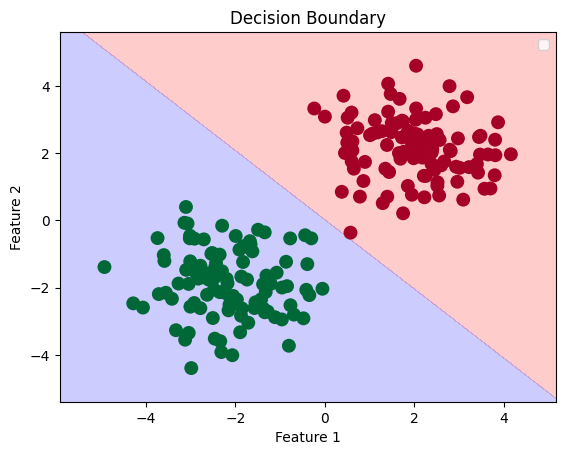

In [15]:
# 定义网格以绘制决策边界
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# 计算每个网格点的预测值
with torch.no_grad():
    probs = net(grid_tensor).numpy().reshape(xx.shape)

# 绘制等高线和散点图
plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=['red', 'blue'])
plt.scatter(features[:, 0], features[:, 1], c=labels, s=100, lw=0, cmap='RdYlGn')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()